In [5]:
#1. IMPORTAÇÕES

import os #Verifica se o arquivo de dados existe no ambiente
import pandas as pd # Para carregar e manipular os dados (tabelas/Dataframes)
import matplotlib.pyplot as plt # Para desenhar os gráficos, como a curva ROC

#Ferramentas do Scikit-learn (sklearn)
from sklearn.model_selection import train_test_split #Para dividir os dados em treino e teste
from sklearn.compose import ColumnTransformer # Para aplicar transformações diferentes em colunas diferentes
from sklearn.preprocessing import OneHotEncoder # Para converter colunas de texto (categóricas) em números
from sklearn.pipeline import Pipeline # Para organizar o fluxo de pré-processamento e modelo

#Métricas de avaliação
from sklearn.metrics import(
    confusion_matrix, #Calcula a Matriz de confusão
    accuracy_score, # Calcula a Acurácia
    precision_score, # Calcula a Precisão
    recall_score, # Calcula o Recall (Sensibilidade)
    f1_score, # Calcula o F1-Score
    classification_report, # Gera um relatório completo
    roc_curve, #Calcula os pontos da Curva ROC
    roc_auc_score #Calcula a área sob a curva (AUC)

)

#O Modelo de Machine Learning
from xgboost import XGBClassifier #O Classificador XGBoost que vai ser treinado

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [11]:
#2. Funções Auxiliares

def carregar_csv(nome_arquivo = "flights_delays_120.csv"):
  """
    Carrega o arquivo CSV informado.
    Verifica se o arquivo existe antes de tentar ler.
  """
  if os.path.exists(nome_arquivo):
    print(f"Arquivo '{nome_arquivo}' encontrado. Carregando dados...")
    return pd.read_csv(nome_arquivo)

  else:
    #Se receber esse erro, verificar o upload do arquivo
    print(f"ERRO: Arquivo '{nome_arquivo}' não encontrado.")
    raise FileNotFoundError(f"Arquivo {nome_arquivo} não entrado.")

def coluna_alvo(dados):
    """
    Detecta automaticamente a coluna alvo no DataFrame.
    Procura por nomes comuns de coluna alvo.
    """
    # Lista de nomes prováveis para a coluna que queremos prever
    candidatos = ["delayed", "atraso", "alvo", "target", "y"]

    for c in candidatos:
        if c in dados.columns:
            print(f"Coluna alvo detectada: '{c}'")
            return c # [cite: 73]

    # Se não encontrar nenhuma, levanta um erro
    print("ERRO: Nenhuma coluna alvo (como 'delayed' ou 'atraso') foi encontrada.")
    raise KeyError("Coluna alvo não encontrada.")


In [12]:
# --- 3. Carregar e Preparar os Dados ---
# 3.1) Carregar dados
dados = carregar_csv()
alvo = coluna_alvo(dados)

# 3.2) Separar X (features) e y (alvo)
y = dados[alvo] # y é apenas a coluna que queremos prever (ex: "delayed")
X = dados.drop(columns=[alvo]) # X é todo o resto (as features usadas para prever)

# 3.3) Separar colunas categóricas e numéricas
# Isso é crucial para o pré-processamento
# Colunas categóricas (tipo 'object' ou 'string' no pandas)
cat = [c for c in X.columns if X[c].dtype == "object"]
# Colunas numéricas (todas as que não são categóricas)
num = [c for c in X.columns if c not in cat]

print(f"Colunas categóricas identificadas: {cat}")
print(f"Colunas numéricas identificadas: {num}")

# 3.4) Dividir em Treino e Teste
# 75% para treino, 25% para teste
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X, y,
    test_size=0.25, # Define o tamanho do conjunto de teste (25%)
    stratify=y,     # Garante que a proporção de atrasos/não atrasos seja a mesma em treino e teste
    random_state=7  # Garante que a divisão seja sempre a mesma (reprodutibilidade)
)

print(f"Dados divididos: {len(y_treino)} para treino, {len(y_teste)} para teste.")


Arquivo 'flights_delays_120.csv' encontrado. Carregando dados...
Coluna alvo detectada: 'delayed'
Colunas categóricas identificadas: ['airline', 'origin', 'destination', 'weather']
Colunas numéricas identificadas: ['departure_hour', 'day_of_week']
Dados divididos: 90 para treino, 30 para teste.


In [15]:
#4. Pré-processador e Pipeline do Modelo

#4.1) Pré-processador

#Definir o que fazer com cada tipo de coluna
preprocessador = ColumnTransformer([
    # ("nome", transformador, colunas_onde_aplicar)
    ("categoricas", OneHotEncoder(handle_unknown="ignore"), cat),
    ("numericas", "passthrough", num)
])

#4.2)Modelo XGBoost

#Definimos o classificador com alguns parâmetros simples

modelo = XGBClassifier(
    n_estimators = 300,      # Número de árvores (modelos) a serem criados
    learning_rate = 0.08,    # Quão rápido o modelo vai aprender
    max_depth = 6,           # Profundidade máxima de cada árvore
    subsample = 0.9,         # Fração de dados de cada árvore
    coldsample_bytree = 0.7, # Fração de colunas de cada árvore
    eval_metric = "logloss", # Métrica de avaliação interna
    ramdom_state = 7         # Reprodutividade
)

#4.3) Criar e Treinar o Pipeline
# O Pipeline junta o pré-processador e o modelo num fluxo só

pipeline = Pipeline([
    ("prep", preprocessador),
    ("xgb", modelo)
])

#4.4) Treinar

print("Iniciando o trenamento do modelo XGBoost...")
pipeline.fit(X_treino, y_treino)
print("Modelo treinado com sucesso!")

Iniciando o trenamento do modelo XGBoost...
Modelo treinado com sucesso!


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:25:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "coldsample_bytree", "ramdom_state" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [18]:
#5. Predições e Métricas de Desempenho

#5.1) Obter Probabilidades

probas = pipeline.predict_proba(X_teste)[:, 1]

#5.2) Converter para Classe Binéria

#Define o limiar de decisão (threshold) para converter a probabilidade em uma classe binária(0 ou 1)
threshold = 0.5

#Converter as probabilidades em classes preditas(y_pred)

y_pred = (probas >= threshold).astype(int)

#5.3) Matriz de Confusão

#Importar a função necessária para a Matriz de Confusão
from sklearn.metrics import confusion_matrix

#Calcular a Matriz de Confusão(cm)
#Comparar com os Valores reais (y_teste) com os valores previstos(y_pred)

cm = confusion_matrix(y_teste, y_pred)


#Imprimir o título e a Matriz de Confusão

print("--- Métricas de Desempenho (Threshold 0.5) ---")
print("Matriz de Confusão:\n", cm)

#5.4) Métricas principais

#Importar as funções de métricas necessárias
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Calcula e Imprime a Acurácia(Proporção de predições corretas)
print(f"Acurácia: {accuracy_score(y_teste, y_pred):.4f}")

#Calcula e imprime a Predisão
print(f"Precisão: {precision_score(y_teste, y_pred, zero_division=0):.4f}")

#5.5) Relatório de Classificação


# Importa a função de relatório (caso ainda não esteja importada)
from sklearn.metrics import classification_report

#Gera e imprime um relatório de texto com as métricas (Pecisão, Recall, F1-Score)
print("\nRelatório de Classificação:\n", classification_report(y_teste, y_pred))


--- Métricas de Desempenho (Threshold 0.5) ---
Matriz de Confusão:
 [[17  0]
 [ 0 13]]
Acurácia: 1.0000
Precisão: 1.0000

Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        13

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30




--- Curva ROC ---
AUC (Área sob a Curva): 1.0000


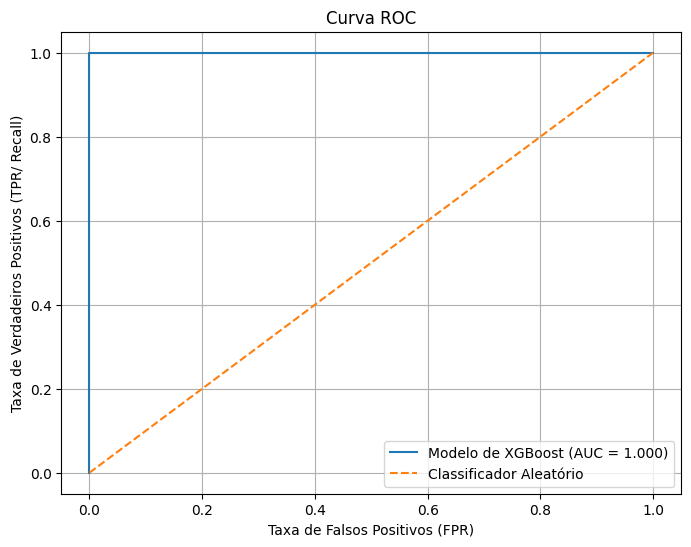

In [19]:
#6. Curva ROC e AUC

#6.1) Calcular ROC e AUC

fpr, tpr, thresholds = roc_curve(y_teste, probas)
auc = roc_auc_score(y_teste, probas)

print("\n--- Curva ROC ---")
print(f"AUC (Área sob a Curva): {auc:.4f}")

#6.2)Plotar o gráfico

plt.figure(figsize=(8,6))
plt.plot(fpr,tpr, label=f"Modelo de XGBoost (AUC = {auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--", label="Classificador Aleatório")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR/ Recall)")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.show()